In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# LOADING THE NECESSARY LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense,Input
from keras.models import Model
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# IMPORTING THE DATASET

In [4]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# DATA VISUALIZATION AND PREPROCESSING

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


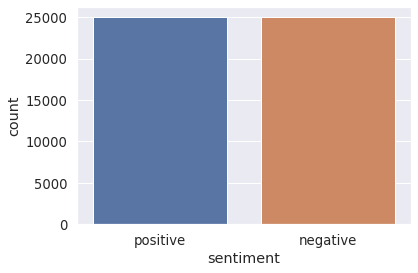

In [6]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

In [7]:
df.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64

In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [10]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


# TRAINING THE MODEL

In [11]:
x_train,x_test,y_train,y_test = train_test_split(df.review,df.sentiment,random_state = 0, stratify = df.sentiment)

**Fast Encoding**

In [23]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [13]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [14]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)

In [15]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [29]:
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

In [30]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 400)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 400, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train,y_train,batch_size = 16 ,validation_data=(x_test,y_test),epochs = 3)

Epoch 1/3
2344/2344 [==============================] - 2110s 900ms/step - loss: 0.3461 - accuracy: 0.8406 - val_loss: 0.2672 - val_accuracy: 0.8903
Epoch 2/3
2344/2344 [==============================] - 2108s 899ms/step - loss: 0.2090 - accuracy: 0.9180 - val_loss: 0.2933 - val_accuracy: 0.8849
Epoch 3/3
2344/2344 [==============================] - 2107s 899ms/step - loss: 0.1099 - accuracy: 0.9599 - val_loss: 0.2936 - val_accuracy: 0.8894


# ANALYSIS AFTER TRAINING OF MODEL

In [34]:
print("Accuracy of the bert model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

391/391 [==============================] - 200s 510ms/step - loss: 0.2936 - accuracy: 0.8894
Accuracy of the bert model on Testing Data is -  88.94400000572205 %


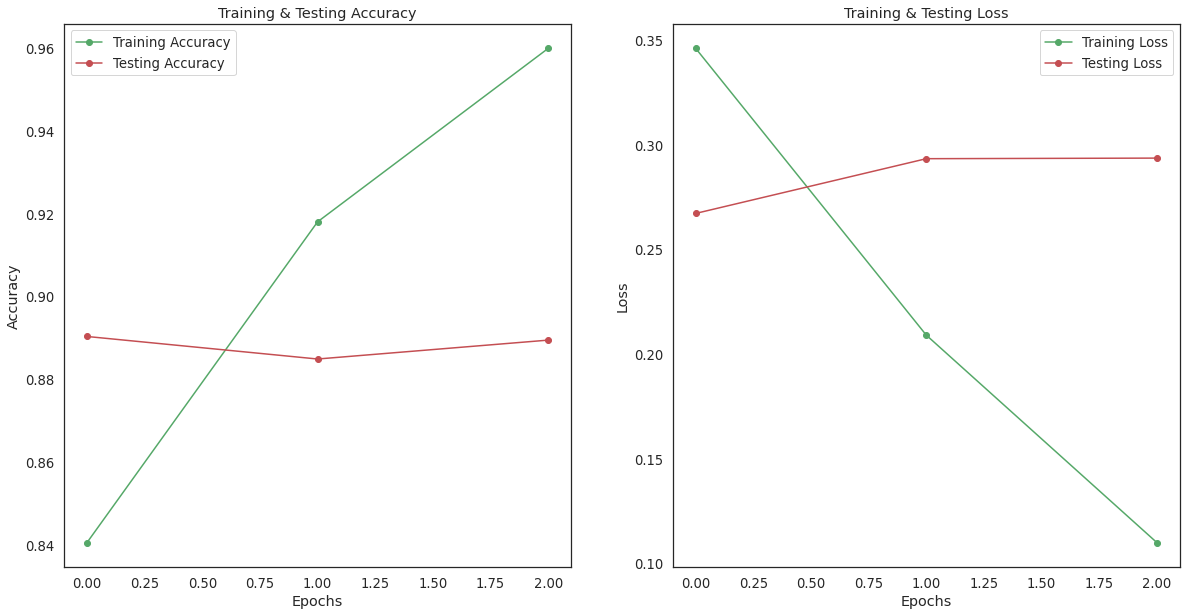

In [35]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [37]:
pred = model.predict(x_test)
pred[:5]

array([[0.98157674],
       [0.00118019],
       [0.02254932],
       [0.11557068],
       [0.53716284]], dtype=float32)

In [38]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [39]:
print(classification_report(y_test, pred, target_names = ['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89      6250
    Positive       0.90      0.88      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



In [40]:
cm = confusion_matrix(y_test,pred)
cm

array([[5620,  630],
       [ 752, 5498]])

Text(62.5, 0.5, 'Actual')

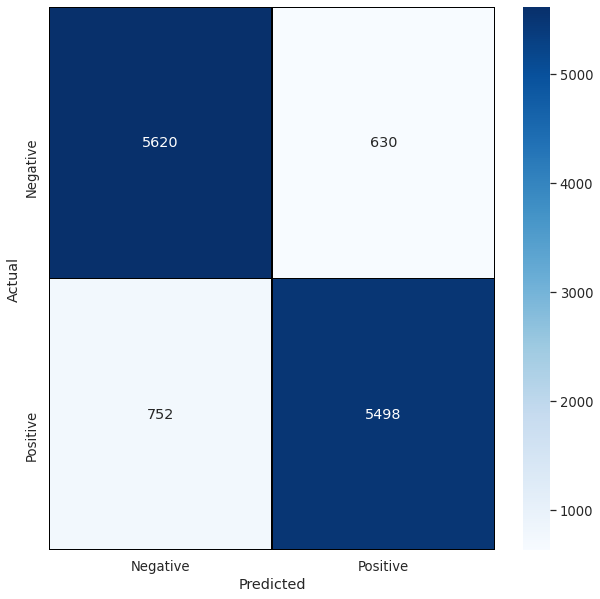

In [42]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Negative','Positive'] , yticklabels = ['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")